# Finite size scaling

In this notebook we will discuss the use of a finite size scaling ansatz to measure properties of a percolating system. So far we've treated the finite systems as if they were in reality infinte.

We will start by finding the percolation threshold $p_{\Pi = x}$ for which the percolation probability $\Pi(p_{\Pi = x}) = x$. That is, we generate many systems of size $L$ with a specific probability $p$ and compute the average percolation probability. We improve on our choice of $p$ until we reach a point where $\Pi(p) \approx x$. The value of $p$ at this point will be $p_{\Pi = x}$.

In [5]:
import numpy as np
import scipy.optimize
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from percolation import compute_percolation_threshold

In [6]:
sns.set()

In [9]:
L_list = [25, 50, 100, 200, 400, 800]
M = 100

x_high = 0.8
x_low = 0.3

p_pi_high = []
p_pi_low = []

In [10]:
for L in tqdm.tqdm_notebook(L_list):
    p_pi = compute_percolation_threshold(x_high, L, M)
    p_pi_high.append(p_pi)

    p_pi = compute_percolation_threshold(x_low, L, M)
    p_pi_low.append(p_pi)

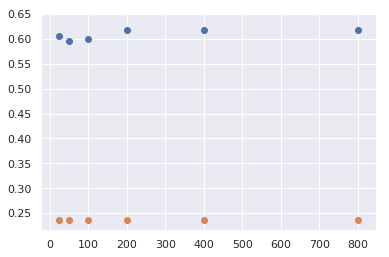

In [16]:
plt.scatter(L_list, p_pi_high)
plt.scatter(L_list, p_pi_low)
plt.show()